In [151]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

SIR com fator de normalização.
$$\ \dot{S} = \frac{- \beta I S}{N}$$
$$\ \dot{I} = \frac{\beta I S}{N} - \gamma I$$
$$\ \dot{R} = - \gamma I S$$
com $$N = S + I + R$$
obs.: variável independente ocultada para simplificar a notação

(é um sistema de EDOs...)

## Redes neurais

### Feedforward

In [152]:
np.random.seed(6661)

In [153]:
# 0 para 160
t = np.linspace(0, 160, 161)

beta = 0.2  # Taxa de infecção
gamma = 0.1  # Taxa de recuperação

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)


def sir_deriv(s_i_r, t0, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    N = S + I + R
    dS = (-beta * S * I) / N
    dI = ((beta * S * I) / N) - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

# random int values between 1000 and 2000
s = np.random.randint(1000, 2000, size=100)
# random int values between 200 and 300
i = np.random.randint(100, 200, size=100)
# random int values between 0 and 100
r = np.random.randint(0, 50, size=100)
x0_o = np.array([s, i, r])

In [154]:
# normalizando SIR de 0 a 1
#s = (s - s.min()) / (s.max() - s.min())
#i = (i - i.min()) / (i.max() - i.min())
#r = (r - r.min()) / (r.max() - r.min())
s = s / 1000
i = i / 1000
r = r / 1000

x0 = np.array([s, i, r]).T
print(x0.shape)

(100, 3)


In [155]:
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])
print(x_t.shape)
x_t[1][0]

(100, 161, 3)


array([1.015, 0.14 , 0.047])

In [156]:
for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
nn_input.shape

(16000, 3)

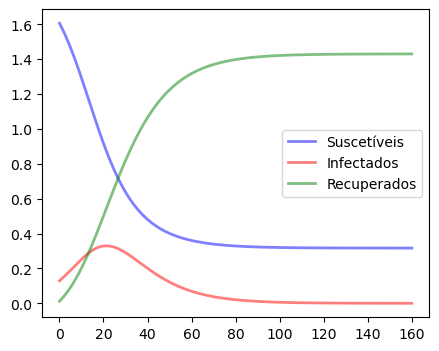

In [157]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x_t[0, :, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x_t[0, :, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x_t[0, :, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

Até aqui tudo certo. Esta é mesmo a "cara" do SIR.

In [158]:
print(nn_input.shape)
print(nn_output.shape)

(16000, 3)
(16000, 3)


In [159]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='linear'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')

In [160]:
History = net.fit(nn_input, nn_output, epochs=10, verbose=1)

Epoch 1/10
500/500 [==============================] - 1s 770us/step - loss: 0.0450
Epoch 2/10
500/500 [==============================] - 0s 754us/step - loss: 0.0013
Epoch 3/10
500/500 [==============================] - 0s 693us/step - loss: 5.8365e-04
Epoch 4/10
500/500 [==============================] - 0s 707us/step - loss: 2.8336e-04
Epoch 5/10
500/500 [==============================] - 0s 731us/step - loss: 1.4559e-04
Epoch 6/10
500/500 [==============================] - 0s 693us/step - loss: 1.0392e-04
Epoch 7/10
500/500 [==============================] - 0s 713us/step - loss: 7.9719e-05
Epoch 8/10
500/500 [==============================] - 0s 699us/step - loss: 5.3481e-05
Epoch 9/10
500/500 [==============================] - 0s 713us/step - loss: 2.7751e-05
Epoch 10/10
500/500 [==============================] - 0s 717us/step - loss: 6.0442e-06


In [161]:
np.random.seed(6661)
ynn = np.zeros((1, len(t), 3))
ynn[0, 0, :] = (np.random.randint(1000, 2000), np.random.randint(100, 200), np.random.randint(0, 50))
# normalizando SIR de 0 a 1
ynn[0, 0, :] = (ynn[0, 0, :] - ynn[0, 0, :].min()) / (ynn[0, 0, :].max() - ynn[0, 0, :].min())
print(ynn[0, 0, :])
for jj, tval in enumerate(t[:-1]):
    ynn[0, jj + 1, :] = net.predict(ynn[:, jj, :], verbose = 1)

[1.         0.05930599 0.        ]
1/1 [==============================] - 0s 13ms/step


In [162]:
y0 = ynn[0, 0, :]
y_t = integrate.odeint(sir_deriv, y0, t)

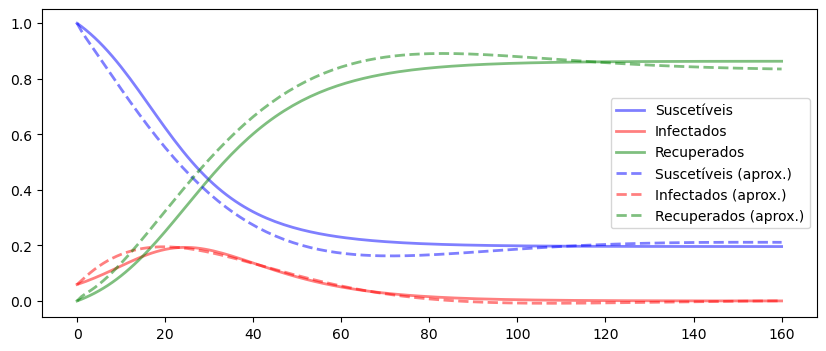

In [163]:
# plot y_t
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, y_t[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, y_t[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, y_t[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
# plot predição
ax.plot(t, ynn[0, :, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, ynn[0, :, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, ynn[0, :, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()

Um resultado similar ao do experimento com o atrator de Lorenz: uma boa aproximação do comportamento, apesar de não muito precisa. Para a baixíssima quantidade de *epochs* e a simplicidade da rede de um modo geral, trata-se de um resultado satisfatório.

Antes deste "sucesso", foram testados: SIR não normalizado, SIR normalizado sem normalização nas entradas, SIR normalizado com normalização nas entradas. Em todos os casos, foi usada a sequência de funções de ativação: ``sigmoid``, ``relu`` e ``linear``, todas sem sucesso

### LSTM

TODO

## Métodos numéricos

### SINDy

In [229]:
beta = 0.2
gamma = 0.1

def sir(s_i_r, t0, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

dt = 0.01
T = 50
t = np.arange(dt,T+dt,dt)
n = 3

In [232]:
np.random.seed(123)
x0 = (1, 0.1, 0)
x = integrate.odeint(sir, x0, t)

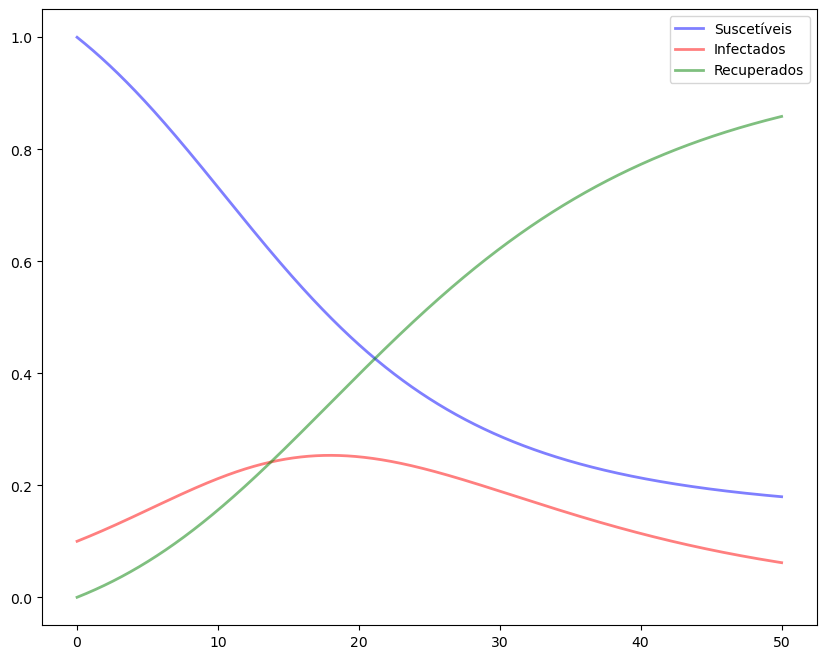

In [244]:
# plot SIR
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

In [235]:
## Compute Derivative
dx = np.zeros_like(x)
for j in range(len(t)):
    dx[j,:] = sir(x[j,:],0,beta,gamma)

In [236]:
## SINDy Function Definitions

def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))
    
    # poly order 0
    yout[:,0] = np.ones(n)
    
    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)
    
    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)
                
    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)
    
    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

In [237]:
Theta = poolData(x,n,3) # Up to third order polynomials
lamb = 0.025 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dx,lamb,n)
Xi

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.1       ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.2       ,  0.10909091,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.09090909,  0.        ],
       [ 0.        , -0.09090909,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [238]:
# Recriando sistema em matriz, resolve a partir do ponto inicial xo
def sindy_system_solve(inputs, t0):
    # Decompõe o inputs em um vetor
    inputs = np.array(inputs).reshape(-1)
    # Neste ponto é necessário conhecer as funções candidatas para progredir
    # E saber como remontar o sistema. Um possível TODO é criar uma relação na geração das candidatas que possa
    # ser reaproveitada nesta função. Aqui, reproduzo as candidatas manualmente.
    candi_vet = np.array([1])
    # Add inputs
    candi_vet = np.append(candi_vet, inputs)
    # Combinação de inputs até ordem 3
    k = 2
    while candi_vet.shape[0] < 20:
        # TODO: otimizável?
        combinations = np.indices((len(inputs),) * k).reshape((k, -1)).T
        unique_combinations = np.unique(np.sort(combinations, axis=1), axis=0)
        selected_combinations = inputs[unique_combinations]
        result = np.prod(selected_combinations, axis=1)
        candi_vet = np.append(candi_vet, result)
        k += 1
    # Tomando a dimensionaliade do sistema como o número de colunas de Xi
    n = Xi.shape[1]
    res = np.zeros(n)
    for i in range(n):
        # Xi[:, i] é a coluna i de Xi, altamente esparasa. Confio que o numpy tenha uma otimização para isso. :)
        res[i] = np.dot(Xi[:, i], candi_vet)
    return res

In [239]:
x_sindy = integrate.odeint(sindy_system_solve, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

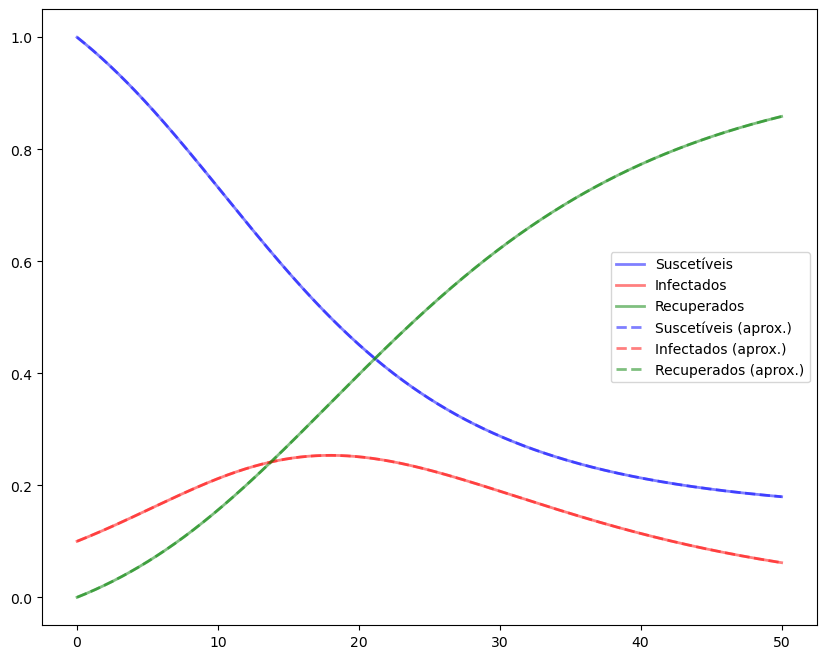

In [243]:
# plot SIR
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
ax.plot(t, x_sindy[:, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, x_sindy[:, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, x_sindy[:, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()